In [3]:
library(tidyverse)
library(ggplot2)
library(stringr)
library(lubridate)
library(readr)
library(odbc)
library(DBI)
library(gridExtra)
library(sf)
library(jpndistrict)
library(purrr)
library(scales)
library(repr)
library(scales)
library(dplyr, warn.conflicts = FALSE)
library(skimr)
library(purrr)
library(estimatr)
library(fixest)
#source("../../../functions/theme_nakahashi.R")
library(viridis)

─ Attaching packages ────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ─

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

─ Conflicts ──────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ─
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




ERROR: Error in library(odbc): there is no package called ‘odbc’


In [4]:
library(data.table)


Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [7]:
library(pander)

In [17]:
require(devtools)
install_github("tlamadon/RcppSimpleTensor")


Loading required package: devtools

Loading required package: usethis




digest (0.6.28 -> 0.6.29) [CRAN]
inline (NA     -> 0.3.19) [CRAN]
Rcpp   (1.0.7  -> 1.0.9 ) [CRAN]


Installing 3 packages: digest, inline, Rcpp

Installing packages into ‘/Users/yusuke.aoki/Library/R/4.0/library’
(as ‘lib’ is unspecified)




  There is a binary version available but the source version is later:
      binary source needs_compilation
Rcpp 1.0.8.3  1.0.9              TRUE


The downloaded binary packages are in
	/var/folders/2v/f5x7qwjs15z1fmv73kf_rp840000gp/T//Rtmp4iATGO/downloaded_packages


installing the source package ‘Rcpp’




✔  checking for file ‘/private/var/folders/2v/f5x7qwjs15z1fmv73kf_rp840000gp/T/Rtmp4iATGO/remotes165f2054004b/tlamadon-RcppSimpleTensor-2a410cc/DESCRIPTION’
─  preparing ‘RcppSimpleTensor’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘RcppSimpleTensor_0.3.tar.gz’
   


Installing package into ‘/Users/yusuke.aoki/Library/R/4.0/library’
(as ‘lib’ is unspecified)



In [19]:
library(testthat)


Attaching package: ‘testthat’


The following object is masked from ‘package:devtools’:

    test_file


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches




## Static Labor Supply

We will consider the decision of the agent under the following rule

$$ max_{c,h}{\frac{c^{1+\eta}}{1+\eta}} -  \beta{\frac{h^{1+\gamma}}{1+\gamma}} $$

$$ s.t. \quad c=\rho*w*h -  r+\mu-\beta_{0}・1[h>0] $$

The individual takes his wage w as given, he chooses hours of work h and consumption c subject to a given non labor income $\mu$ as well as a tax regime defined by $\rho$,r. $\beta_{0}$ is a fixed cost associated with working.

We note already that the non labor income can control for dynamic labor supply since we can have $\mu=b_{t}−(1+r)b_{t+1}$. This is part of a larger maximization problem where the agents choose optimaly bt over time. We will get there next time.


### Interior solution

F.O.C gives us $ w(wh+r-\mu)^{\eta}-\beta h^{\gamma} $. There is no clsoed-form but we can very quickly find an interior solution by using newton maximiaion on the function $ f(x)=w(wh+r-\mu)^{\eta}-\beta h^{\gamma} $. We iterate on

$$ x \leftarrow x - f(x)/f'(x) $$ 

In [1]:
# function which updates choice of hours using Newton step
# R here is total unearned income (including taxes when not working and all)
ff.newt <- function(x,w,R,eta,gamma,beta) {
  f0 = w*(w*x + R)^eta - beta*x^gamma
  f1 =  eta*w^2 * (w*x + R)^(eta-1) - gamma * beta *x^(gamma-1)
  x  = x - f0/f1 
  x  = ifelse(w*x + R<=0, -R/w + 0.0001,x) # make sure we do not step out of bounds for next iteration
  x  = ifelse(x<0, 0.0001,x)
  return(x)
}


### Simulating Data

We are going to simulate a data set where agents will choose participation as well as the number of hours if they decide to work. To do that we will solve for the interior solution under a given tax rate and compare this to the option of no-work.

In [5]:
p  = list(eta=-1.5,gamma = 0.8,beta=1,beta0=0.1) # define preferences
tx = list(rho=1,r=0) # define a simple tax
N=1000
simdata = data.table(i=1:N,X=rnorm(N))
simdata[,lw := X     + rnorm(N)*0.2];      # add a wage which depends on X
simdata[,mu := exp(0.3*X + rnorm(N)*0.2)]; # add non-labor income that also depends on X

# we then solve for the choice of hours and consumption
simdata[, h := pmax(-mu+tx$r + p$beta0 ,0)/exp(lw)+1] # starting value
# for loop for newton method (30 should be enough, it is fast)
for (i in 1:30) {
  simdata[, h := ff.newt(h,tx$rho*exp(lw),mu-tx$r-p$beta0,p$eta,p$gamma,p$beta) ]
}

# attach consumption, value of working
simdata[, c  := exp(lw)*h + mu - p$beta0];
simdata[, u1 := c^(1+p$eta)/(1+p$eta) - p$beta * h^(1+p$gamma)/(1+p$gamma) ];

In [13]:
tmp_summary<-pander(summary(simdata[,lm(lw ~ log(c) + log(h))]))
#display_markdown(tmp_summary)



|     &nbsp;      |  Estimate  | Std. Error |  t value  | Pr(>|t|)  |
|:---------------:|:----------:|:----------:|:---------:|:---------:|
| **(Intercept)** | -2.022e-15 | 2.169e-16  |  -9.322   | 7.123e-20 |
|   **log(c)**    |    1.5     | 1.027e-16  | 1.461e+16 |     0     |
|   **log(h)**    |    0.8     | 2.565e-16  | 3.119e+15 |     0     |



| Observations | Residual Std. Error | $R^2$ | Adjusted $R^2$ |
|:------------:|:-------------------:|:-----:|:--------------:|
|     1000     |      1.938e-15      |   1   |       1        |

Table: Fitting linear model: lw ~ log(c) + log(h)



### Adding participation

We simply compute the value of choosing h=0, then take the highest of working and not working.

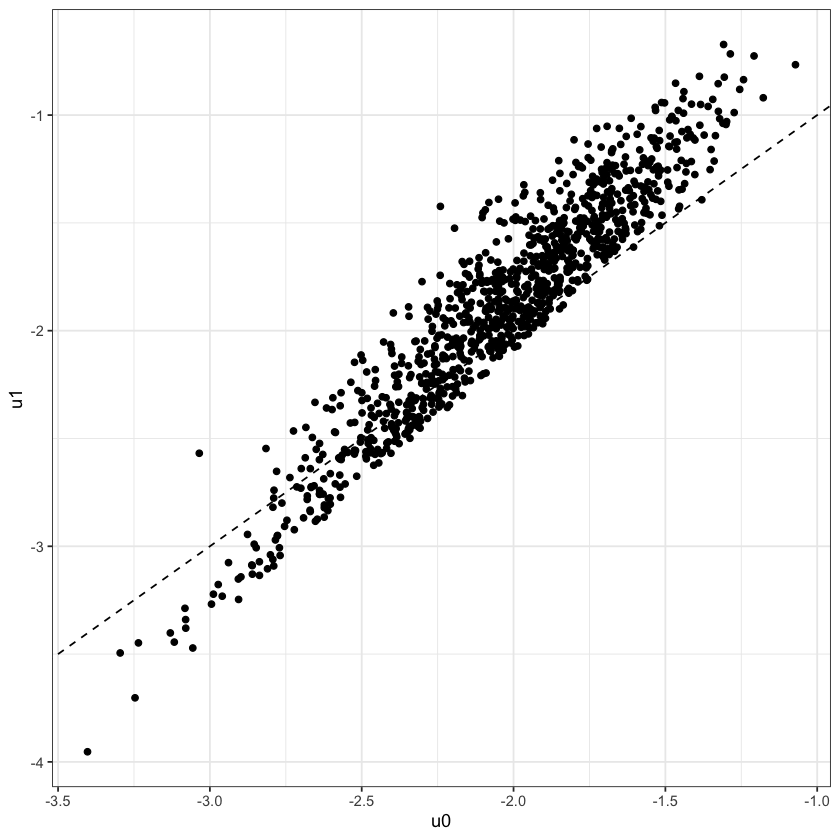

In [14]:
simdata[,u0:=  mu^(1+p$eta)/(1+p$eta)];
simdata[,p1:=u1>u0]
ggplot(simdata,aes(x=u0,y=u1)) + geom_point() + geom_abline(linetype=2) + theme_bw()

In [15]:
pander(summary(simdata[p1==TRUE,lm(lw ~ log(c) + log(h))]))



|     &nbsp;      | Estimate | Std. Error |  t value  | Pr(>|t|)  |
|:---------------:|:--------:|:----------:|:---------:|:---------:|
| **(Intercept)** | 1.53e-15 | 1.666e-16  |   9.183   | 3.757e-19 |
|   **log(c)**    |   1.5    | 6.656e-17  | 2.253e+16 |     0     |
|   **log(h)**    |   0.8    | 2.469e-16  | 3.241e+15 |     0     |



| Observations | Residual Std. Error | $R^2$ | Adjusted $R^2$ |
|:------------:|:-------------------:|:-----:|:--------------:|
|     776      |      9.702e-16      |   1   |       1        |

Table: Fitting linear model: lw ~ log(c) + log(h)



### Heterogeneity in $\beta$

Finally we want to add heterogeneity in the β parameter.

In [20]:
simdata[,betai := exp(0.5*X+rnorm(N)*0.1)]
simdata[, h := pmax(-mu+tx$r + p$beta0 ,0)/exp(lw)+1]
for (i in 1:30) {
  simdata[, h := ff.newt(h,tx$rho*exp(lw),mu-tx$r-p$beta0,p$eta,p$gamma,betai) ]
}

# attach consumption
simdata[, c  := exp(lw)*h + mu - p$beta0];
simdata[, u1 := c^(1+p$eta)/(1+p$eta) - betai * h^(1+p$gamma)/(1+p$gamma) ];
simdata[, u0:=  mu^(1+p$eta)/(1+p$eta)];
simdata[,p1:=u1>u0]

# let's check that the FOC holds
sfit = summary(simdata[,lm(lw ~ log(c) + log(h) + log(betai))])
expect_equivalent(sfit$r.squared,1)
expect_equivalent(coef(sfit)["log(c)",1],-p$eta)
expect_equivalent(coef(sfit)["log(h)",1],p$gamma)

sfit = summary(simdata[p1==TRUE,lm(lw ~ log(c) + log(h))])
expect_false(coef(sfit)["log(c)",1]==-p$eta)


Warning message in summary.lm(simdata[, lm(lw ~ log(c) + log(h) + log(betai))]):
“essentially perfect fit: summary may be unreliable”


In [21]:
pander(sfit)



|     &nbsp;      | Estimate | Std. Error | t value |  Pr(>|t|)  |
|:---------------:|:--------:|:----------:|:-------:|:----------:|
| **(Intercept)** | -0.5608  |  0.01451   | -38.66  | 1.386e-190 |
|   **log(c)**    |  2.096   |   0.0214   |  97.95  |     0      |
|   **log(h)**    |  0.2631  |  0.02867   |  9.176  | 3.217e-19  |



| Observations | Residual Std. Error | $R^2$  | Adjusted $R^2$ |
|:------------:|:-------------------:|:------:|:--------------:|
|     867      |       0.1515        | 0.9699 |     0.9698     |

Table: Fitting linear model: lw ~ log(c) + log(h)



In [22]:
sfit


Call:
lm(formula = lw ~ log(c) + log(h))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.51009 -0.09630  0.00479  0.10415  0.46122 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.56082    0.01451 -38.656   <2e-16 ***
log(c)       2.09594    0.02140  97.947   <2e-16 ***
log(h)       0.26307    0.02867   9.176   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1515 on 864 degrees of freedom
Multiple R-squared:  0.9699,	Adjusted R-squared:  0.9698 
F-statistic: 1.391e+04 on 2 and 864 DF,  p-value: < 2.2e-16


#### Simple case of $\eta=0$

In [23]:
p=list(eta=0,gamma=0.8,beta=1,beta0=0,nu=0.5) # define preferences
tx=list(rho=1,r=0) # define a simple tax
N=500

In [24]:
tx$rho

[1] 1

In [25]:
simdata=data.table(i=1:N,X=rnorm(N))

In [26]:
simdata%>%head()

i,X
<int>,<dbl>
1,-2.90735856
2,-0.04262519
3,0.45962900
4,-0.65484758
5,0.29090349
6,0.65212503


In [29]:
simdata<-simdata[,lw:=X+rnorm(N)*0.2]; # addd a wage with depends on X
simdata<-simdata[,mu:=exp(0.3*X +rnorm(N)*0.2)]; # add non-labor income that also depends on X
simdata<-simdata[,eps:=rnorm(N)*0.1];
simdata<-simdata[,betai:=exp(p$nu*X+eps)];
simdata<-simdata[,h:=(tx$rho*exp(lw)/betai)^(1/p$gamma)];
simdata%>%head()

i,X,lw,mu,eps,betai,h
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-2.90735856,-2.8352463,0.5115266,-0.065525817,0.2188858,0.1930026
2,-0.04262519,-0.1166115,0.8105578,0.008149149,0.9869228,0.8787015
3,0.45962900,0.2881069,1.0907082,-0.151061772,1.0819368,1.2991273
4,-0.65484758,-0.6944905,0.8682428,0.081057744,0.7816361,0.5711202
5,0.29090349,0.2618219,1.3924673,-0.106612455,1.0396034,1.3214483
6,0.65212503,0.6003370,1.3559250,0.044989580,1.4492586,1.3318996


In [30]:
sfit3 = summary(simdata[,lm(log(h) ~ lw + X)])
pander(sfit3)



|     &nbsp;      | Estimate  | Std. Error | t value |  Pr(>|t|)  |
|:---------------:|:---------:|:----------:|:-------:|:----------:|
| **(Intercept)** | -0.003364 |  0.005473  | -0.6146 |   0.5391   |
|     **lw**      |   1.166   |  0.02807   |  41.54  | 9.394e-164 |
|      **X**      |  -0.5488  |   0.0286   | -19.19  |  8.22e-62  |



| Observations | Residual Std. Error | $R^2$  | Adjusted $R^2$ |
|:------------:|:-------------------:|:------:|:--------------:|
|     500      |       0.1223        | 0.9687 |     0.9686     |

Table: Fitting linear model: log(h) ~ lw + X



In [31]:
sfit4 = summary(simdata[,lm(lw ~ log(h) + X)])
pander(sfit4)



|     &nbsp;      | Estimate | Std. Error | t value |  Pr(>|t|)  |
|:---------------:|:--------:|:----------:|:-------:|:----------:|
| **(Intercept)** | 0.001736 |  0.004136  | 0.4197  |   0.6749   |
|   **log(h)**    |  0.6658  |  0.01603   |  41.54  | 9.394e-164 |
|      **X**      |  0.5893  |  0.01069   |  55.11  | 7.881e-214 |



| Observations | Residual Std. Error | $R^2$  | Adjusted $R^2$ |
|:------------:|:-------------------:|:------:|:--------------:|
|     500      |       0.09241       | 0.9923 |     0.9923     |

Table: Fitting linear model: lw ~ log(h) + X



Then we can construct a counter-factual revenue

In [33]:
p2  = list(eta=0,gamma = 1/sfit3$coefficients["lw","Estimate"],beta=1,beta0=0)
tx2 = tx
tx2$rho = 0.9
simdata <- simdata[, h2 := (tx2$rho*exp(lw)/betai)^(1/p2$gamma)]

simdata[, list(totearnings =mean(exp(lw+h)), 
               R1=mean((1-tx$rho)*exp(lw+h)),
               R2=mean((1-tx2$rho)*exp(lw+h2)) ,
               R3=mean((1-tx2$rho)*exp(lw+h)) )]

totearnings,R1,R2,R3
<dbl>,<dbl>,<dbl>,<dbl>
45.63602,0,2.042992,4.563602


#### Heterogeneity in $\beta$ revisited

Finally we want to add heterogeneity in the beta parameter

In [34]:
p  = list(eta=-1.5,gamma = 0.8,beta=1,beta0=0,nu=0.5) # define preferences
tx = list(rho=1,r=0) # define a simple tax
N=5000
simdata = data.table(i=1:N,X=rnorm(N))
simdata <- simdata[,lw := X     + rnorm(N)*0.2];      # add a wage which depends on X
simdata <- simdata[,mu := exp(0.3*X + rnorm(N)*0.2)]; # add non-labor income that also depends on X
simdata <- simdata[,eps := rnorm(N)*0.1]
simdata <- simdata[,betai := exp(p$nu*X+eps)]
simdata <- simdata[, h := (tx$rho*exp(lw)/betai)^(1/p$gamma)]
simdata <- simdata[, betai := exp(p$nu*X+rnorm(N)*0.1)]
simdata <- simdata[, h := pmax(-mu+tx$r ,0)/exp(lw)+1]

In [ ]:
# function which updates choice of hours using Newton step
# R here is total unearned income (including taxes when not working and all)
ff.newt <- function(x,w,R,eta,gamma,beta) {
  f0 = w*(w*x + R)^eta - beta*x^gamma
  f1 =  eta*w^2 * (w*x + R)^(eta-1) - gamma * beta *x^(gamma-1)
  x  = x - f0/f1 
  x  = ifelse(w*x + R<=0, -R/w + 0.0001,x) # make sure we do not step out of bounds for next iteration
  x  = ifelse(x<0, 0.0001,x)
  return(x)
}


In [35]:
for (i in 1:30) {
  simdata <- simdata[, h := ff.newt(h,tx$rho*exp(lw),mu-tx$r,p$eta,p$gamma,betai) ]
}

In [36]:
# attach consumption
simdata <- simdata[, c  := exp(lw)*h + mu];

In [37]:
# let's check that the FOC holds
sfit = summary(simdata[,lm(lw ~ log(c) + log(h) + log(betai))])

In [39]:
sfit


Call:
lm(formula = lw ~ log(c) + log(h) + log(betai))

Residuals:
       Min         1Q     Median         3Q        Max 
-1.562e-14 -1.370e-16 -3.000e-18  1.120e-16  7.069e-14 

Coefficients:
             Estimate Std. Error   t value Pr(>|t|)    
(Intercept) 1.306e-15  6.459e-17 2.022e+01   <2e-16 ***
log(c)      1.500e+00  8.944e-17 1.677e+16   <2e-16 ***
log(h)      8.000e-01  7.263e-17 1.101e+16   <2e-16 ***
log(betai)  1.000e+00  8.247e-17 1.213e+16   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.061e-15 on 4996 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 1.558e+33 on 3 and 4996 DF,  p-value: < 2.2e-16


In [40]:
expect_equivalent(sfit$r.squared,1)

In [41]:
-p$eta

[1] 1.5

In [42]:
expect_equivalent(sfit$r.squared,1)
expect_equivalent(coef(sfit)["log(c)",1],-p$eta)
expect_equivalent(coef(sfit)["log(h)",1],p$gamma)

In [43]:
sfit2 = summary(simdata[,lm(lw ~ log(c) + log(h))])
expect_false(coef(sfit2)["log(c)",1]==-p$eta)

sfit3 = summary(simdata[,lm(lw ~ log(c) + log(h) + X)])
pander(sfit2)



|     &nbsp;      | Estimate | Std. Error | t value | Pr(>|t|) |
|:---------------:|:--------:|:----------:|:-------:|:--------:|
| **(Intercept)** | -0.5393  |  0.008036  | -67.11  |    0     |
|   **log(c)**    |  2.427   |  0.007955  |  305.1  |    0     |
|   **log(h)**    |  0.6115  |  0.01217   |  50.24  |    0     |



| Observations | Residual Std. Error | $R^2$  | Adjusted $R^2$ |
|:------------:|:-------------------:|:------:|:--------------:|
|     5000     |       0.1821        | 0.9685 |     0.9685     |

Table: Fitting linear model: lw ~ log(c) + log(h)



Next we have established the following condition in the class:

$$ E[log(w)-\gamma log(h)-\eta log(c)+\nu x| W,R,X]=0 $$
This suggests an IV strategy where we instrument using W,R,X. We can use either hours or consumption as a dependent variable and instrument the other. We use h and implement using 2SLS (identical to IV in this case). We then first regress c on the three variables to get the predicted component, that we then use in a regression.

In [ ]:
# 

In [46]:
fit_c=simdata[,lm(log(c)~lw+log(mu)+X)]
simdata[,c_iv:=predict(fit_c)]

sfit_iv2=simdata[,lm(log(h)~c_iv + lw + X )]
pander(sfit_iv2)



|     &nbsp;      | Estimate | Std. Error | t value | Pr(>|t|) |
|:---------------:|:--------:|:----------:|:-------:|:--------:|
| **(Intercept)** | 0.004115 |  0.007797  | 0.5278  |  0.5976  |
|    **c_iv**     |  -1.89   |  0.01805   | -104.7  |    0     |
|     **lw**      |  1.241   |  0.01114   |  111.4  |    0     |
|      **X**      | -0.6083  |  0.008334  | -72.99  |    0     |

Table: Fitting linear model: log(h) ~ c_iv + lw + X



Where we find as regression coefficients $1/\gamma$ and $\eta/\gamma $. Note of course that the inference out of the second regression is no valid

### Heckman selection

we cover here a simple version of the heckman selection. In the labor supply homework, you will see a version of this closer to the structure of the model presented at the beginning of this page.

we start with the following model:

$$  y_{i}^{*}=\gamma x_{i}+\epsilon_{i}  $$
$$  d_{i}=1[\delta_{1}x_{i}+\delta_{2}z_{i}+u_{i} \geq 0] $$
$$  y_{i}=d_{i}+y_{i}^{*}  $$

And only $  (y_{i},d_{i},x_{i},z_{i})  $ are observed. We assume that $(\epsilon_{i},u_{i})$ are jointly normal, mean zero and independent of xi.

In [47]:
N=5000
p = list(gamma = 1.0, delta1 = 0.8, delta2 = 0.8, alpha = 1.0, sigma_v = 1.0, sigma_u = 1.0)
X = 2*runif(N)-1
Z = 2*runif(N)-1
U = p$sigma_u * rnorm(N)
D = p$delta1 * X + p$delta2 * Z + U >= 0 
E = p$alpha * U + p$sigma_v * rnorm(N)
Ys = p$gamma * X + E 

data = data.table(y = Ys * D, ys=Ys, d = D, x=X,z=Z,e=E,u=U)
data[ d==FALSE, y:=NA]
data%>%head()

y,ys,d,x,z,e,u
<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.05559057,-0.05559057,TRUE,0.5526028,-0.02831522,-0.6081934,1.2321173
NA,-0.37066144,FALSE,-0.2532811,-0.85533089,-0.1173803,-0.7778158
NA,-3.38040688,FALSE,0.6122099,0.05430389,-3.9926168,-2.1308626
NA,1.50770074,FALSE,0.2506134,-0.29065708,1.2570873,-0.1103597
NA,-1.72751550,FALSE,-0.4069174,0.02249527,-1.3205981,-0.9249931
0.37186064,0.37186064,TRUE,-0.4452799,0.74295608,0.8171405,0.3717077


While $E[\epsilon_{i}|x_{i}]=0$ we can’t use that for identification since what we observe is $(y_{i},x_{i})$ and note $(y_{i}^{*},x_{i})$, so we can’t construct $E[y_{i}^{*}x_{i}].$

We then need to rely on something else. We are going to look at$E[y_{i}^{*}x_{i}|d_{i}]\geq 0]$.which is then equal to $E[y_{i}x_{i}|d_{i}]\geq 0]$ which is observed!

In [48]:
fit1 = lm(y ~ x,data)
summary(fit1)


Call:
lm(formula = y ~ x, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8662 -0.8545 -0.0271  0.8376  4.4771 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.73897    0.02657   27.82   <2e-16 ***
x            0.63552    0.04574   13.89   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.265 on 2536 degrees of freedom
  (2462 observations deleted due to missingness)
Multiple R-squared:  0.07075,	Adjusted R-squared:  0.07038 
F-statistic: 193.1 on 1 and 2536 DF,  p-value: < 2.2e-16


`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



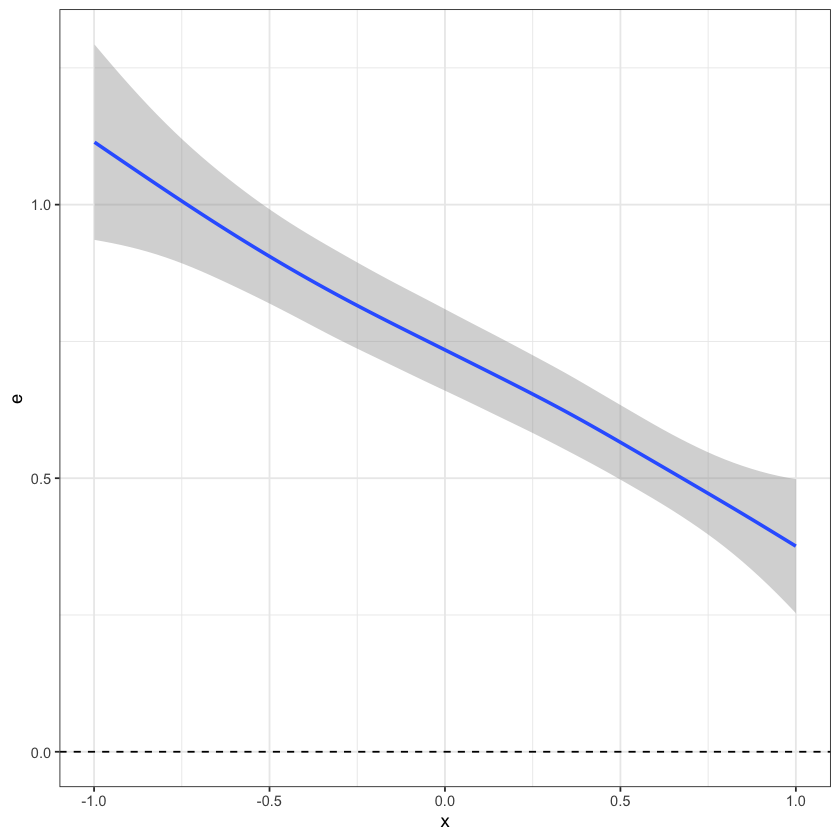

In [49]:
#ggplot(data, aes(x = x, y= e)) + geom_smooth() + 
#  theme_bw() + geom_hline(yintercept=0,linetype=2)
ggplot(data[d==TRUE], aes(x = x, y= e)) + geom_smooth() + 
  theme_bw() + geom_hline(yintercept=0,linetype=2)

We then look at
$$E[y_{i}|x_{i},z_{i},d_{i}=1]=E[y_{i}^{*}|x_{i},z_{i},d_{i}=1]\\
                                     =E[\gamma x_{i}+\epsilon_{i}|x_{i},z_{i},d_{i}=1]  \\
                                     =\gamma x_{i}+E[\epsilon_{i}|x_{i},z_{i},d_{i}=1]$$

(ϵi,ui) are jointly normal so we know we can write ϵi=αui+vi where vi is normal, mean zero and independent of ui. We can then write the conditional expectation as follows:

$$E[\epsilon_{i}|x_{i},z_{i},d_{i}=1]=E[\epsilon_{i}^{*}|x_{i},z_{i},\delta_{2}z_{i}+u_{i}\geq 0]\\
                                     =E[\alpha u_{i}+v_{i}|x_{i},z_{i},\delta_{1}x_{i}+\delta_{2}z_{i}+u_{i} \geq 0]  \\
                                     =\alpha E[u_{i}|x_{i},z_{i},\delta_{1}x_{i}+\delta_{2}z_{i}+u_{i} \geq 0]+E[v_{i}|x_{i},z_{i},\delta_{1}x_{i}+\delta_{2}z_{i}+u_{i} \geq 0]\\
                                     =\alpha E[u_{i}|x_{i},z_{i},\delta_{1}x_{i}+\delta_{2}z_{i}+u_{i} \geq 0]\\
                                     =\alpha E[u_{i}|u_{i} \geq -\delta_{1}x_{i}-\delta_{2}z_{i}]$$

Which means that we need a value for δ1σu and δ2σu. Luckily the participation decision given by δ2zi+δ1xi+ui≥0 and so the probit regression of di on zi and xi gives precisely these coefficients!

In [50]:
fit2 = glm(d ~ x + z, family = binomial('probit'), data)
summary(fit2)


Call:
glm(formula = d ~ x + z, family = binomial("probit"), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4016  -0.9692   0.3948   0.9603   2.2355  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 0.005758   0.019148   0.301    0.764    
x           0.793001   0.034194  23.192   <2e-16 ***
z           0.841250   0.034149  24.635   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 6930.3  on 4999  degrees of freedom
Residual deviance: 5754.2  on 4997  degrees of freedom
AIC: 5760.2

Number of Fisher Scoring iterations: 3
